# TP : Entraînez-vous à entraîner un algorithme de Machine Learning !

## 1. Introduction 

### 1.1 Preprocess 

To begin with this problem, we will remove outliers (appartement costing more than 10 000€ / month), and we will remove appartement with missing value. 

In [1]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
## stat / model : 
from sklearn.model_selection import train_test_split


In [2]:
### EXTRACTION DATA ###
# On charge le dataset
house_data = pd.read_csv(data_path+'house_data_complete.csv')
print(house_data.head(2),"\n")

# OUTLIERS
print("Before removing outliers, there are ", house_data.shape[0], "considered appartements")
house_data = house_data[house_data['price'] < 8000]
# plt.plot(house_data['surface'], house_data['price'], 'ro', markersize=4)
# plt.show()

## REMOVING NaNs :
print("Before removing uncomplete data (NaNs), there are ", house_data.shape[0], "considered appartements")

#house_data.dropna(axis=0, how = any) 
house_data.dropna(inplace=True) 

print("After preprocessing, there are", house_data.shape[0], "considered appartements")


   price  surface  arrondissement
0   1820     46.1             1.0
1   1750     41.0             1.0 

Before removing outliers, there are  827 considered appartements
Before removing uncomplete data (NaNs), there are  817 considered appartements
After preprocessing, there are 812 considered appartements


### 1.2 First graphical analysis
My pb : the considered arrondissement are the 1,2,3,4 and 10 -> 10 gives sad color + legend ugly
It was not that easy to tackle the legend. 

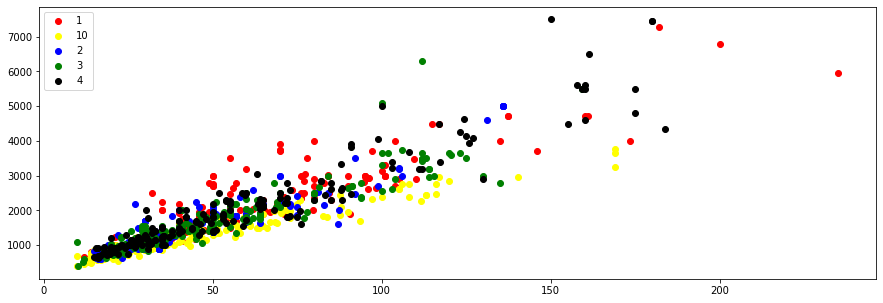

In [3]:
df = house_data.copy()
df["arr"]= df['arrondissement'].map(int).map(str)
colors = {'1':'red', '2':'blue', '3':'green', '4':'black', '10':'yellow'}
grouped = df.groupby('arr')
for key, group in grouped:
    plt.scatter(group["surface"], group["price"], label=key, color=colors[key] ) 
plt.legend()
plt.show()

We see that we have a different slopes for each arrondissement, thus it is a good idea to add this information in the linear model. Let us (as in the correction) see a boxplot in each arrondissement :

<AxesSubplot:title={'center':'surface'}, xlabel='arr'>

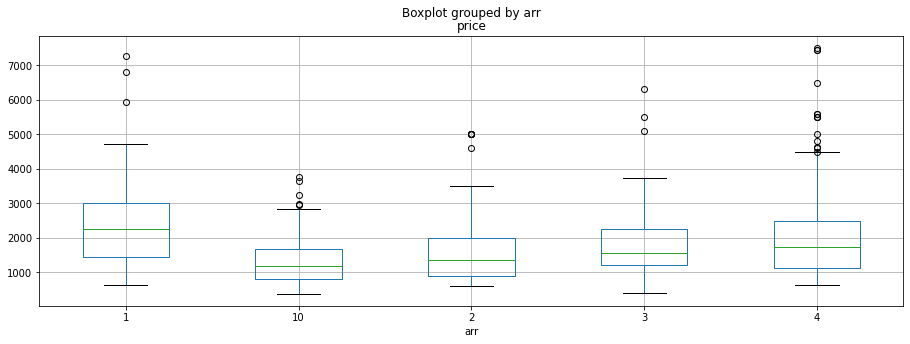

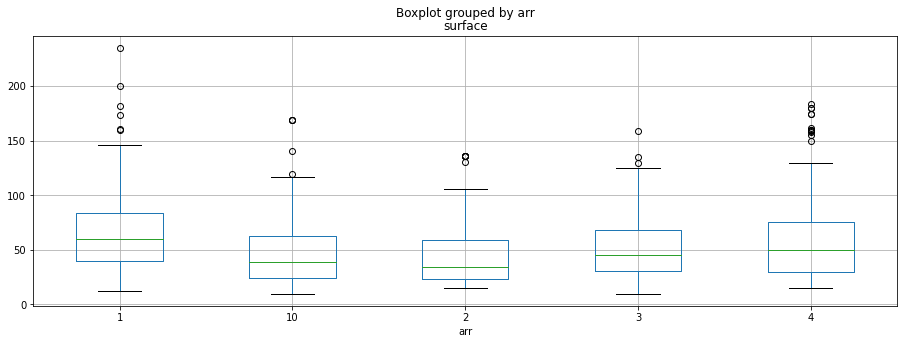

In [4]:
df.drop("arrondissement", axis=1, inplace=False).boxplot(by="arr", column="price")
df.drop("arrondissement", axis=1, inplace=False).boxplot(by="arr", column="surface")

### 1.3 Recall of Linear Regression syntaxe : 

After slipping the train and test sets, I use the sklearn method "sklearn.linear_model.LinearRegression" and train it on data, as it was done in the course :

In [5]:
## syntaxe with numpy -> tackle the intercept in pandas ?? 
# X = (np.matrix([np.ones(house_data.shape[0]), house_data['surface'].values])).T
# y = np.matrix(house_data['price']).T

X = np.matrix(house_data['surface']).T
y = house_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## DEFINE MODEL :
from sklearn import linear_model
regr = linear_model.LinearRegression()

## TRAINING : 
regr.fit(X_train, y_train)

print(regr.score(X_test,y_test)) 

tmp = pd.DataFrame(y_test).copy()
tmp["predicted"] = regr.predict(X_test)
tmp.head(3)


0.867296192554557


,price,predicted
646,1000,984.621297
382,1350,1906.492478
219,2506,2684.321288


## 2. One Linear Regression for each arrondissement : 

As we know that there is a different comportement in each arrondissement, instead of training one general linear regression, I will train K=5 different linear regression as : 

<center>price$_{\text{arr} k}$ = coeff$_{\text{arr} k}$ * surface + shift$_{\text{arr}k}$ </center>

I first looped on the index of [1,2,3,4,10] the vector of arrondissements. Then i discovered the groupby method witch is really more efficient, that's why I commented this first idea : 
<code> 
X = house_data[['surface','arrondissement']]
y = house_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## DEFINE MODEL :
from sklearn import linear_model
dict_regr_k = {}


## TRAINING arrondissement by arrondissement -> 5 linear regr: 
for k in np.unique(X_train["arrondissement"]):
    index_train_k = (X_train["arrondissement"]==k).index
    X_train_k = np.matrix(X_train["surface"][index_train_k]).T
    y_train_k = y_train[index_train_k]
    
    regr = linear_model.LinearRegression()
    regr.fit(X_train_k, y_train_k)
    dict_regr_k[str(int(k))]= regr    
</code>

In [6]:
### SAMPLING
## DESIGN MATRIX X=(surface, arr) : 
X = house_data[['surface','arrondissement']]
## replace "arrondissement" (type = float) with "arr" (type = str(int(float)))
X["arr"] = X['arrondissement'].map(int).map(str)
X.drop("arrondissement", axis = 1, inplace=True)

## TARGET VECTOR y = price  :
y = house_data['price']

## SAMPLING TRAIN/TEST :
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
### TRAINING PART OF LR :
## INITIALIZE LINEAR REGRESSION (in a dict) :
dict_regr_k = {}

## TRAINING arrondissement by arrondissement -> 5 linear regr: 
grouped = X_train.groupby('arr')
for key, X_train_k in grouped : 
    y_train_k = y_train[X_train_k.index]
    regr = linear_model.LinearRegression()
    regr.fit(np.matrix(X_train_k["surface"]).T, y_train_k)
    dict_regr_k[key]= regr
    
#     ## OVER-FITTED MODEL (just to be sure of the code) :
#     reg_k = dict_regr_k[key]
#     predicted_price_k = reg_k.predict(np.matrix(X_train_k["surface"]).T)
#     plt.scatter(X_train_k["surface"], y_train_k, label=key, color=colors[key] ) 
#     plt.plot(X_train_k["surface"], predicted_price_k , color = colors[key])

Let's create a function that, given a sample test of house data, return directly the prediction (thus, that call the right linear regression fitted on the corresponding arrondissement data) : 

Now that the linear regressions are fitted (recall : one LR for each arrondissement), on can see the prediction in the test sample. One can separe 3 main outputs : 
* the prediction itself
* the graph of the linear regression for each arrondissement
* the score of prediction

Remark : The sklearn method "score" will depend on each arrondissement, as we have 5 LR. We will need to find another implementation of $R^2$ to have the global error of this multi-regression

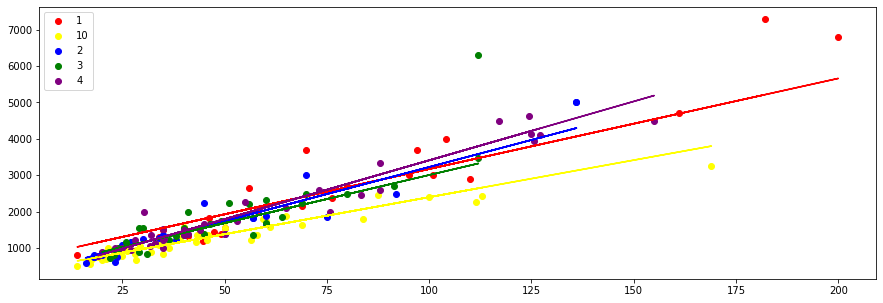

{'1': 0.861797632351459,
 '10': 0.8951992279614698,
 '2': 0.9082209415400224,
 '3': 0.6762371883136507,
 '4': 0.9307877255646396}

In [8]:
## MODEL PREDICTION ON TEST DATA : SCORING, GRAPH AND PREDICTION

index_test = X_test.index
colors = {'1':'red', '2':'blue', '3':'green', '4':'purple', '10':'yellow'}

## INIT           
res = X_test.copy()
res['price'] = y_test
res['prediction'] = pd.Series(dtype="float64")
scores_by_k = {}

## LOOP ON ARR :
grouped = X_test.groupby('arr')
for key, X_test_k in grouped:
    index_k_test = X_test_k.index
    y_test_k = y_test[index_k_test] 
    
    ## PREDICTION
    reg_k = dict_regr_k[key]
    predicted_price_k = reg_k.predict(np.matrix(X_test_k["surface"]).T)
    res.loc[index_k_test,"prediction"]= predicted_price_k
    
    ## SCORES :
    scores_by_k[key] = reg_k.score(np.matrix(X_test_k["surface"]).T,y_test_k)
    
    ## PLOTS
    plt.scatter(X_test_k["surface"], y_test_k, label=key, color=colors[key] ) 
    plt.plot(X_test_k["surface"], predicted_price_k , color = colors[key])
plt.legend()
plt.show()

scores_by_k

Interpretation : The 1st and 2nd arrondissement have really volatile ratio price/surface, and the error commited for these arrondissement is more important.The error in the other arrondissement is smaller : the LR better predict in case-by-case model. 

I have stocked the prediction in the "res" DataFrame : 

In [9]:
res.head(5)

,surface,arr,price,prediction
493,88.0,4,2595,3024.053675
282,57.0,2,1835,1951.578039
196,30.0,2,1250,1150.274140
276,18.0,2,799,794.139073
498,88.0,4,3350,3024.053675


Let's now create a $R^2$ global calculus, to measure the improvement in term of prediction performance, by introducting this variable "arrondissement" : 

I have been inspired by the correction code 

In [10]:
def norm2(x,y):
    return sum((x - y)**2)

def r2score(pred, target):
    return 1 - norm2(pred, target) / norm2(target, np.mean(target))

score_bl = r2score(res["prediction"],res["price"])

print(score_bl)

0.8713320966451308


The global $R^2$ is better with our new model (simple LR, $R^2 = 0.8367117915160818


## 3. Combined model : can we train a global linear regression ? 
### 3.1 Introducing the importance of each variable : 


To train our linear regression, we will need to create the $X$ matrix as : 

$$ X = \begin{pmatrix}
1 & loyer & arr_1(1) & arr_2(1) & \dots & arr_12(1)\\
& & &\dots & &  \\
1 & loyer & arr_1(i) & arr_2(i) & \dots & arr_12(i) \\
& & & \dots & &\\
1 & loyer & arr_1(n) & arr_2(n) & \dots & arr_12(n) 
\end{pmatrix} 
$$

Where 
* k = 1 ... K are the arrondissements
* i = 1 ... n are the appartements
* arr_k(i) is a boolean variable and equals to 1 if the $i^{th}$ appartement is the $k^{th}$ arrondissement, 0 otherwise. 

Indeed, the arrondissement information is a categorial info and not a numerical one. In a first approche, we will consider the arrondissement and surface without putting a weight (see after) 

So, we first need to construct the 0-1 submatrice size $k \times n$, denoted A, containing the information about arrondissement. We will first construct it with a loop and then we will use a pandas.Dataframe method to do it more properly :

Even thought the results doesn't seem that bad, I am not happy with this modelisation : I did not control how the arrondissement is important compared to the surface of the appartement. To do it, let's introduce an hyperparemeter $\mu$ that enable me to controle the weight/importance of the categorial and numerical variable. The idea is to set the better (in term of training) $\mu$ such that
<center>price = $\mu$ * surface + (1-$\mu$) * $\mathbb{1}_{\text{arrondissement}} + C^{\text{te}}$   </center>
    
As we know that the surface is really larger that 1, one can imagine that the mu parameter will be  
Note that this code is not optimized at all, but I gave some semantic variables to easy the lecture.

In [11]:
## BY HAND METHOD : 
K = np.int(max(house_data["arrondissement"]))
n = house_data.shape[0]
A = np.zeros((n,K))

for k in range(K): 
    A[house_data["arrondissement"]==k,k]=1

TODO test unitaire : vérifier que sum(sum(A))==n

In [12]:
## WITH PANDAS METHOD : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

Concatenate a 1 vector, $A$ and "surface" column of data_house to get $X$

In [13]:
X = np.concatenate((np.matrix([np.ones(house_data.shape[0]), house_data['surface'].values]),A.T)).T
y = np.matrix(house_data['price']).T

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


In [14]:
regr = linear_model.LinearRegression()
K = len(np.unique(house_data["arrondissement"])) # number of different arr
list_lr=[]

for j in range(K) :
    # j is the column number in X_train, see above 
    app_in_k_train = np.where(X_train[:,2+j]==1)[0]
    X_train_k = X_train[app_in_k_train,:2]
    y_train_k = y_train[app_in_k_train]
    
    regr.fit(X_train_k, y_train_k)
    
#     app_in_k_test = np.where(X_test[:,2+j]==1)[0]
#     X_test_k = X_test[app_in_k_test,:2]
#     y_test_k = y_test[app_in_k_test]
    
    list_lr.append(regr)

In [15]:
## CATEGORICAL VARIABLE MATRIX : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

## MODEL MATRIX WITH HYPERPARAMETER MU : 
y = np.matrix(house_data['price']).T
# semantic variables :
surface = house_data['surface'].values
shift = np.ones(house_data.shape[0])
arrondissement = A.T
      
mu = 0.5                
X_mu = np.concatenate((np.matrix([shift, mu*surface]) , (1-mu)*arrondissement)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


The issue with this choise is that the train/test sets depend on mu, and it is not our aim. So I think it is a better practice to split the data independantly of mu and modify it after the X_train and X_test. That's what I do now : 

In [16]:
## CATEGORICAL VARIABLE MATRIX : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

## MODEL MATRIX WITH HYPERPARAMETER MU : 
y = np.matrix(house_data['price']).T
# semantic variables :
surface = house_data['surface'].values
shift = np.ones(house_data.shape[0])
arrondissement = A.T
               
X = np.concatenate((np.matrix([shift, surface]) , arrondissement)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [17]:
def mu_weigth_on_X0(VarX,Varmu):
    res = VarX.copy()
    res[:,1] = Varmu*res[:,1]
    res[:,2:] = (1-Varmu)*res[:,2:]
    return(res)

def mu_weigth_on_X(VarX,Varmu):
    res = VarX.copy()
    res[:,2:] = Varmu*res[:,2:]
    return(res)

mu = 0.5
X_train_mu = mu_weigth_on_X(X_train,mu)
## TRAINING 
regr = linear_model.LinearRegression() 
regr.fit(X_train_mu, y_train)


LinearRegression()

So, we can loop on different vaues of mu to set the better model. The differents methods to split the dataset are presented after (Leave One Out, KFold, Cross Validation). I used the sklearn CV routine : 

In [18]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(regr, X_train_mu, y_train, cv=10)
print(cv_results['test_score'].mean())

0.8558977157335977


In [19]:
regr = linear_model.LinearRegression() 

mu_values = np.arange(0,10000,10)
reg_scores = []
for mu in mu_values : 
    X_train_mu = X_train.copy()
    X_train_mu[:,2:] = mu*X_train_mu[:,2:]
    #X_train_mu = mu_weigth_on_X(X_train,mu)
#     print(X_train_mu[:3,])
    ## LINEAR REGRESSION :
    #regr.fit(X_train_mu, y_train)
    cv_results = cross_validate(regr, X_train_mu, y_train, cv=10)
    
    reg_scores.append(cv_results['test_score'].mean())

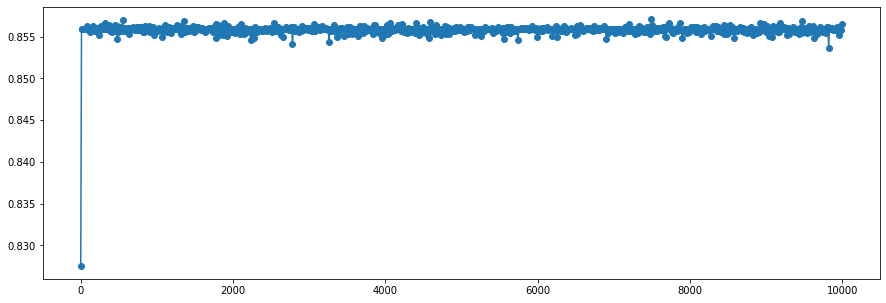

In [20]:
plt.plot(mu_values,reg_scores,'-o')

In [21]:
X_train_mu[0,]

matrix([[1.00e+00, 3.00e+01, 0.00e+00, 0.00e+00, 9.99e+03, 0.00e+00,
         0.00e+00]])

In [22]:
X_train[0,]

matrix([[ 1., 30.,  0.,  0.,  1.,  0.,  0.]])